In [98]:
import pandas as pd
import numpy as np
import seaborn as sns

import requests
from urllib.parse import urlencode

from scipy.stats import levene
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

import warnings

In [99]:
# filtering warnings
warnings.filterwarnings('ignore')

In [100]:
#Выгружаем данные
ab_users_data = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'
 
def get_yandex_download_url(public_key):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url
ab_users_data = pd.read_csv(get_yandex_download_url(ab_users_data), sep=';')

In [101]:
ab_users_data

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Проверка данных

In [102]:
#Проверим есть ли в колонках пустые значения - нет
ab_users_data.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [103]:
#Проверим типы данных
ab_users_data.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [104]:
#Проверим на наличие дубликатов
ab_users_data.loc[ab_users_data.duplicated()]

,user_id,revenue,testgroup


Выбрать подходящую метрику или метрики.
1. ARPU средний доход на пользователя (чем выше, тем лучше). Целевая метрика
2. Конверсия в платежи (доля платящих пользователей) (чем выше, тем лучше). Целевая метрика

#### 1. ARPU средний доход на пользователя

Так как ARPU - это средний доход на пользователя, будем брать revenue для каждого конеретного юзера.

Проверим есть ли несколько значений revenue для user_id.

In [105]:
df_agg = ab_users_data.groupby(['user_id', 'testgroup'], as_index=False) \
        .agg({'revenue': 'sum'})

In [106]:
df_agg

,user_id,testgroup,revenue
0,1,b,0
1,2,a,0
2,3,a,0
3,4,b,0
4,5,b,0
...,...,...,...
404765,404766,a,0
404766,404767,b,0
404767,404768,a,231
404768,404769,a,0


Количество строк не изменилось. Значит в группировке нет смысла. Будем использовать исходные данные ab_users_data

1.1 Проверка нормальности распределения:
Тест Шапиро-Уилка

In [107]:
# Тест Шапиро-Уилка для контрольной группы
_, control_p_value = shapiro(ab_users_data.query("testgroup == 'a'").revenue)
print("Контрольная группа: p-значение =", control_p_value)

# Тест Шапиро-Уилка для тестовой группы
_, test_p_value = shapiro(ab_users_data.query("testgroup == 'b'").revenue)
print("Тестовая группа: p-значение =", test_p_value)


Контрольная группа: p-значение = 0.0
Тестовая группа: p-значение = 0.0


1.2 Проверка однородности дисперсий

Тест Левена

In [108]:
stat, p = levene(ab_users_data.query("testgroup == 'a'").revenue, ab_users_data.query("testgroup == 'b'").revenue)

alpha = 0.05
if p > alpha:
    print('Дисперсии похожи (не отвергаем H0)')
else:
    print('Дисперсии не похожи (отвергаем H0)')


Дисперсии похожи (не отвергаем H0)


1.3 Посмотрим гистограммы

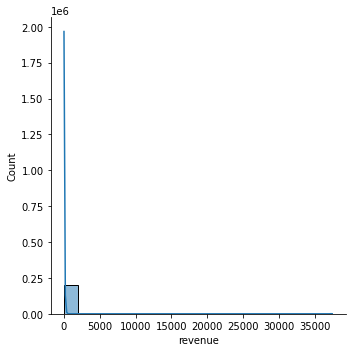

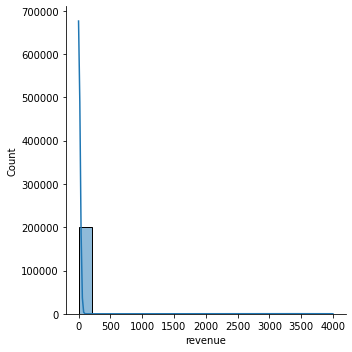

In [109]:
sns.displot(data=ab_users_data.query("testgroup == 'a'"), x="revenue", kde=True)
sns.displot(data=ab_users_data.query("testgroup == 'b'"), x="revenue", kde=True)

1.4 Посмотрим гистограммы с логарифмированными значениями

In [113]:
ab_users_data["revenue_log"] = np.log(ab_users_data.revenue)

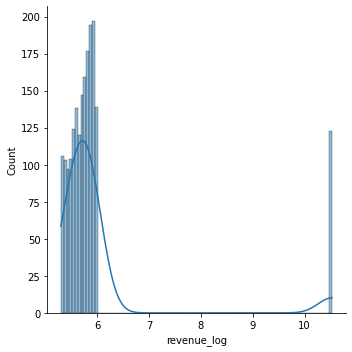

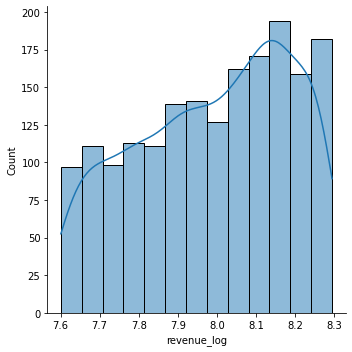

In [114]:
sns.displot(data=ab_users_data.query("testgroup == 'a'"), x="revenue_log", kde=True)
sns.displot(data=ab_users_data.query("testgroup == 'b'"), x="revenue_log", kde=True)

Согласно тестам данные не имеют нормального распределения, однако, размер выборок более 30 --> оценки параметричности и нормальности могут выдавать ошибочные результаты. Также, вступает в силу Центральная предельная теорема.

Согласно гистограммам распределение можно считать нормальным. Для группы А большая часть значений сконцентрирована у 0. Для группы Б визально можно принять распределение за нормальное.

Так как дисперсии существенно различаются, перестрахуемся и воспользуемся Welch's t-test, который более устойчив к нарушению предположения об однородной дисперсии.

1.5 Тест Welch's t-test

In [115]:
# Выполняем Welch's t-test
t_statistic, p_value = ttest_ind(ab_users_data.query("testgroup == 'a'").revenue, ab_users_data.query("testgroup == 'b'").revenue, equal_var=False)

# Оценка статистической значимости
alpha = 0.05
if p_value < alpha:
    print("Различия в ARPU статистически значимы (применяя Welch's t-test).")
else:
    print("Различия в ARPU не являются статистически значимыми (применяя Welch's t-test).")


Различия в ARPU не являются статистически значимыми (применяя Welch's t-test).


#### ARPU вывод: 

Для целевых параметров получили статически НЕ значимые различия. Значит сравнить средние значения ARPU не целесообразно.

In [116]:
agg = ab_users_data.groupby(['testgroup'], as_index=False) \
                .agg({'revenue': 'sum', 'user_id': pd.Series.nunique})
agg['ARPU'] = agg.revenue / agg.user_id

agg

,testgroup,revenue,user_id,ARPU
0,a,5136189,202103,25.413720
1,b,5421603,202667,26.751287


#### 2. Конверсия в платежи (доля платящих пользователей)

Так как необходимо оценить различие между дискретными значениями, то воспользуемся хи-квадрат тестом. 

In [117]:
#Подготовим данные для теста
ab_users_data['revenue_flag'] = np.where(ab_users_data.revenue == 0, 0, 1)
hi_data = ab_users_data.groupby(['testgroup'], as_index=False) \
                        .agg({'revenue_flag': ['sum', 'count']})

hi_data.columns = ['testgroup', 'sum', 'count']
hi_data["count"] = hi_data["count"] - hi_data["sum"]

hi_data

,testgroup,sum,count
0,a,1928,200175
1,b,1805,200862


In [118]:
stat, p_value, _, _ = chi2_contingency(hi_data.drop(columns= ['testgroup']))

alpha = 0.05

if p_value < alpha:
    print("Различия в конверсии в платежи статистически значимы (с использованием хи-квадрат теста).")
else:
    print("Различия в конверсии в платежи не являются статистически значимыми (с использованием хи-квадрат теста).")

Различия в конверсии в платежи статистически значимы (с использованием хи-квадрат теста).


#### Конверсия в платежи вывод: 

Для целевого параметра получили статически значимые различия. Значит сравнить средние значения конверсий в платежи целесообразно.

In [119]:
hi_data["conversion"] = (hi_data["sum"] / hi_data["count"] * 100).round(2)
hi_data

,testgroup,sum,count,conversion
0,a,1928,200175,0.96
1,b,1805,200862,0.90


In [120]:
((hi_data.conversion[1] / hi_data.conversion[0] - 1) * 100).round(2)

-6.25

1. Целевая метрика. ARPU средний доход на пользователя (чем выше, тем лучше).
Тест не показат стат значимости. Соответственно не можем сравнить средние значения тестовых групп.

2. Целевая метрика. Средние значения конверсий в платежи (чем выше, тем лучше).
Для тестовой группы А на 6.25% при статичтической значимости расхождений. Может говорить о том, что пользователи в тестовой группе А конвертируются в покупателей чаще. Соответственно приносят прибыль продукту.

ИТОГ: предлагается оставлять версию продукта, которую использовала тестовая группа А.